# Arctic-EDS Data Preparation - Mean / Min / Max July / Jan Temperature

## Objectives
This notebook will execute the necessary preprocessing of data prior to being ingested into Rasdaman. The scope of this notebook will cover two "plates" in the original Environmental Atlas of Alaska.

### Plates
#### Mean / Min / Max July Temperature
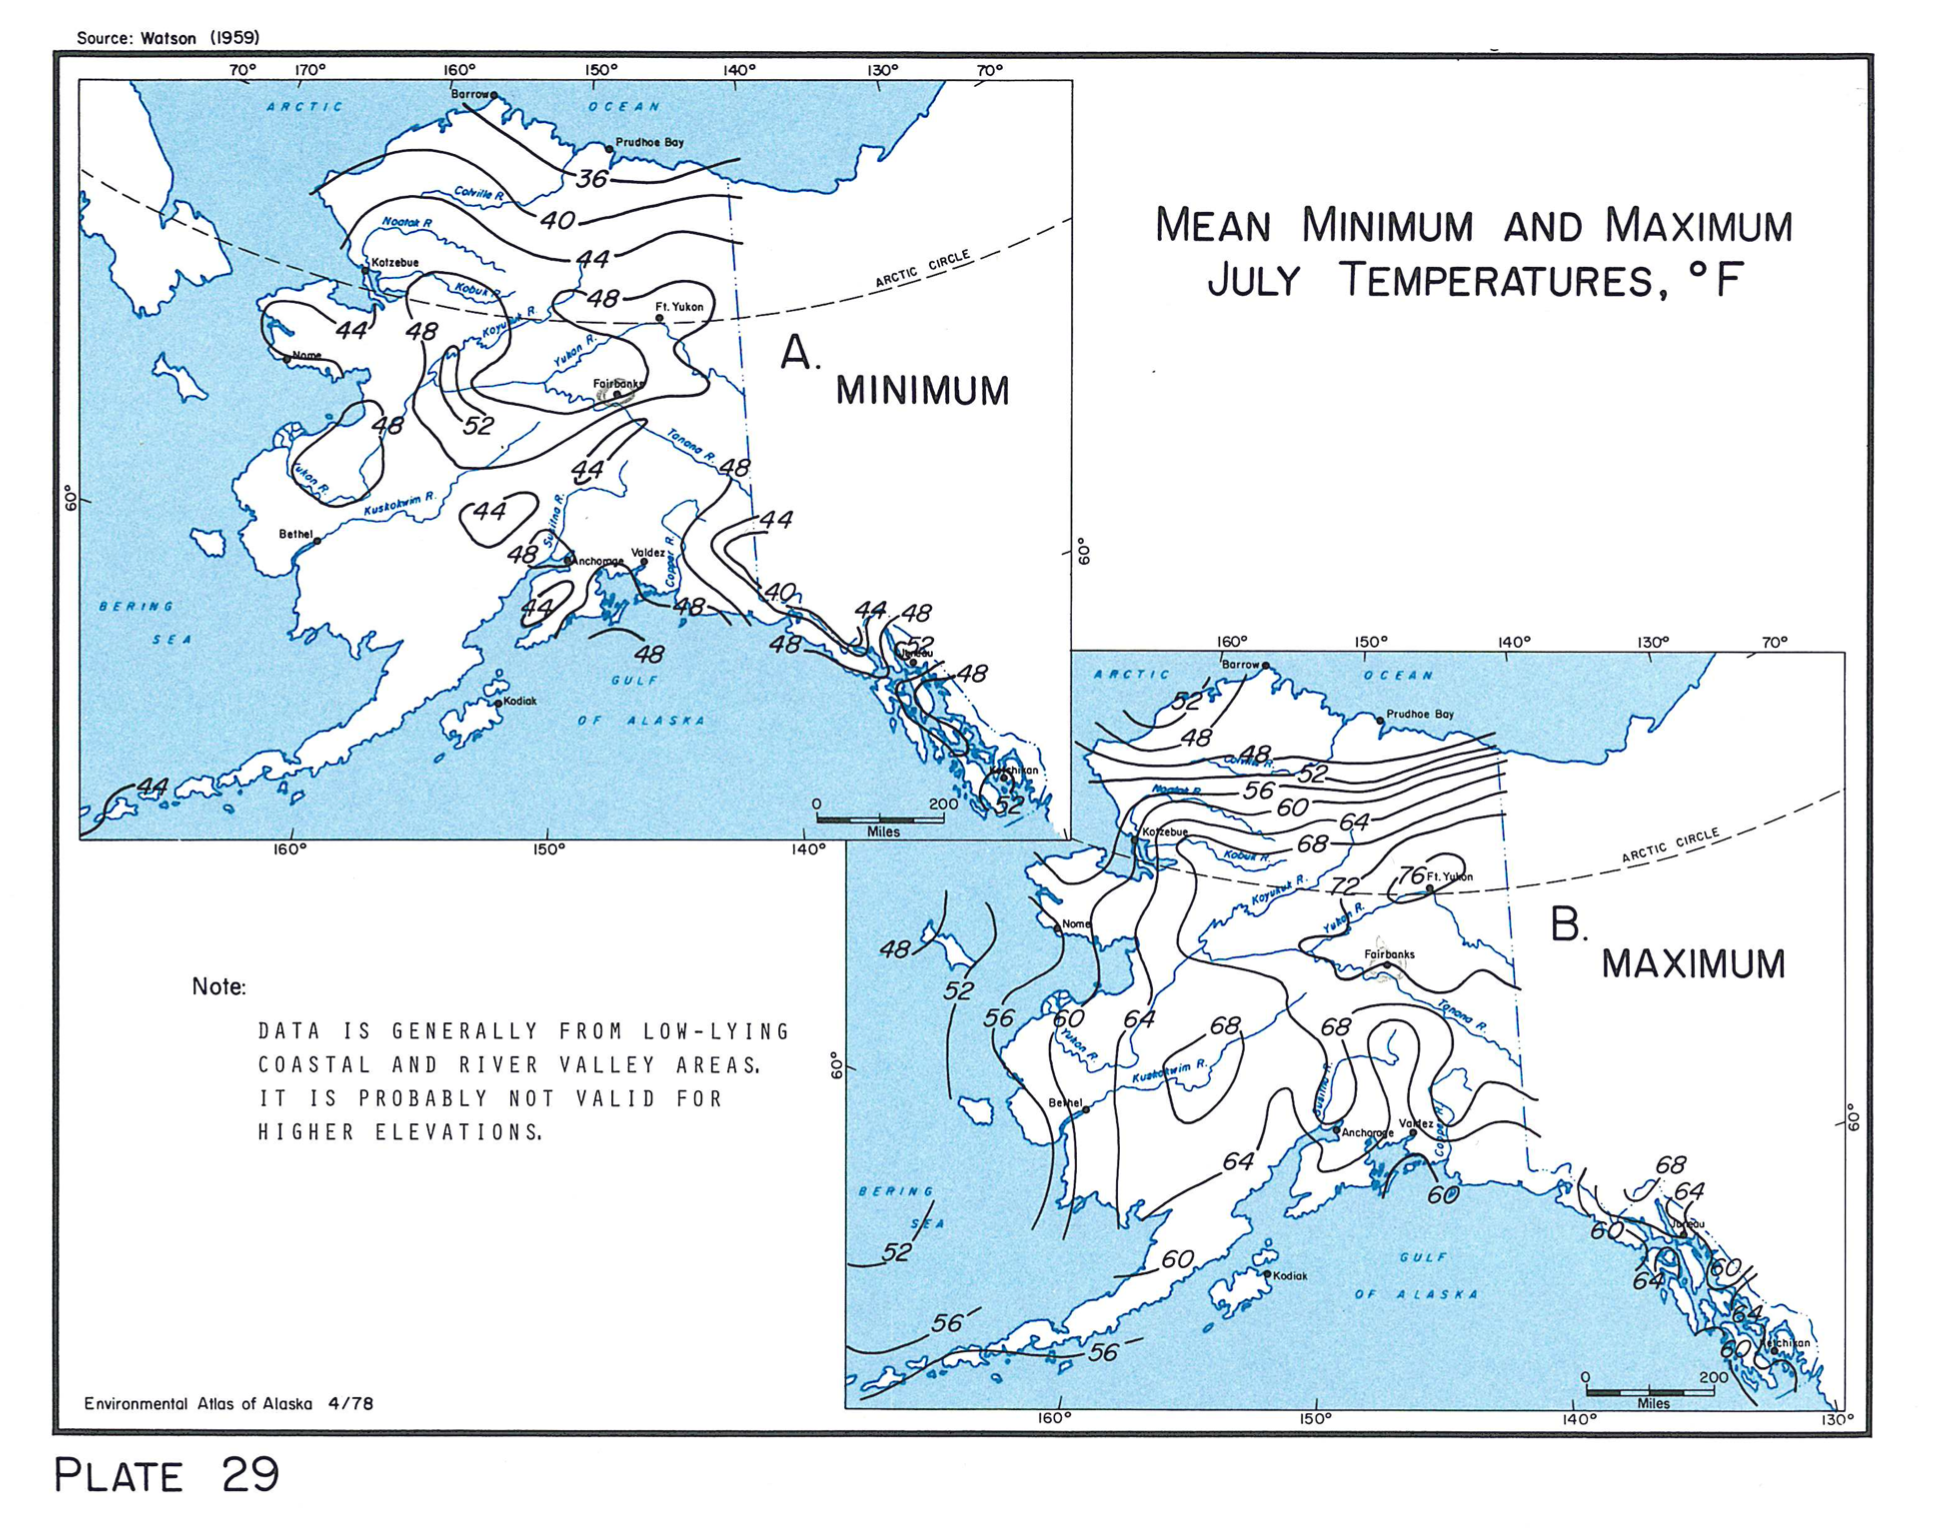

#### Mean / Min / Max January Temperature
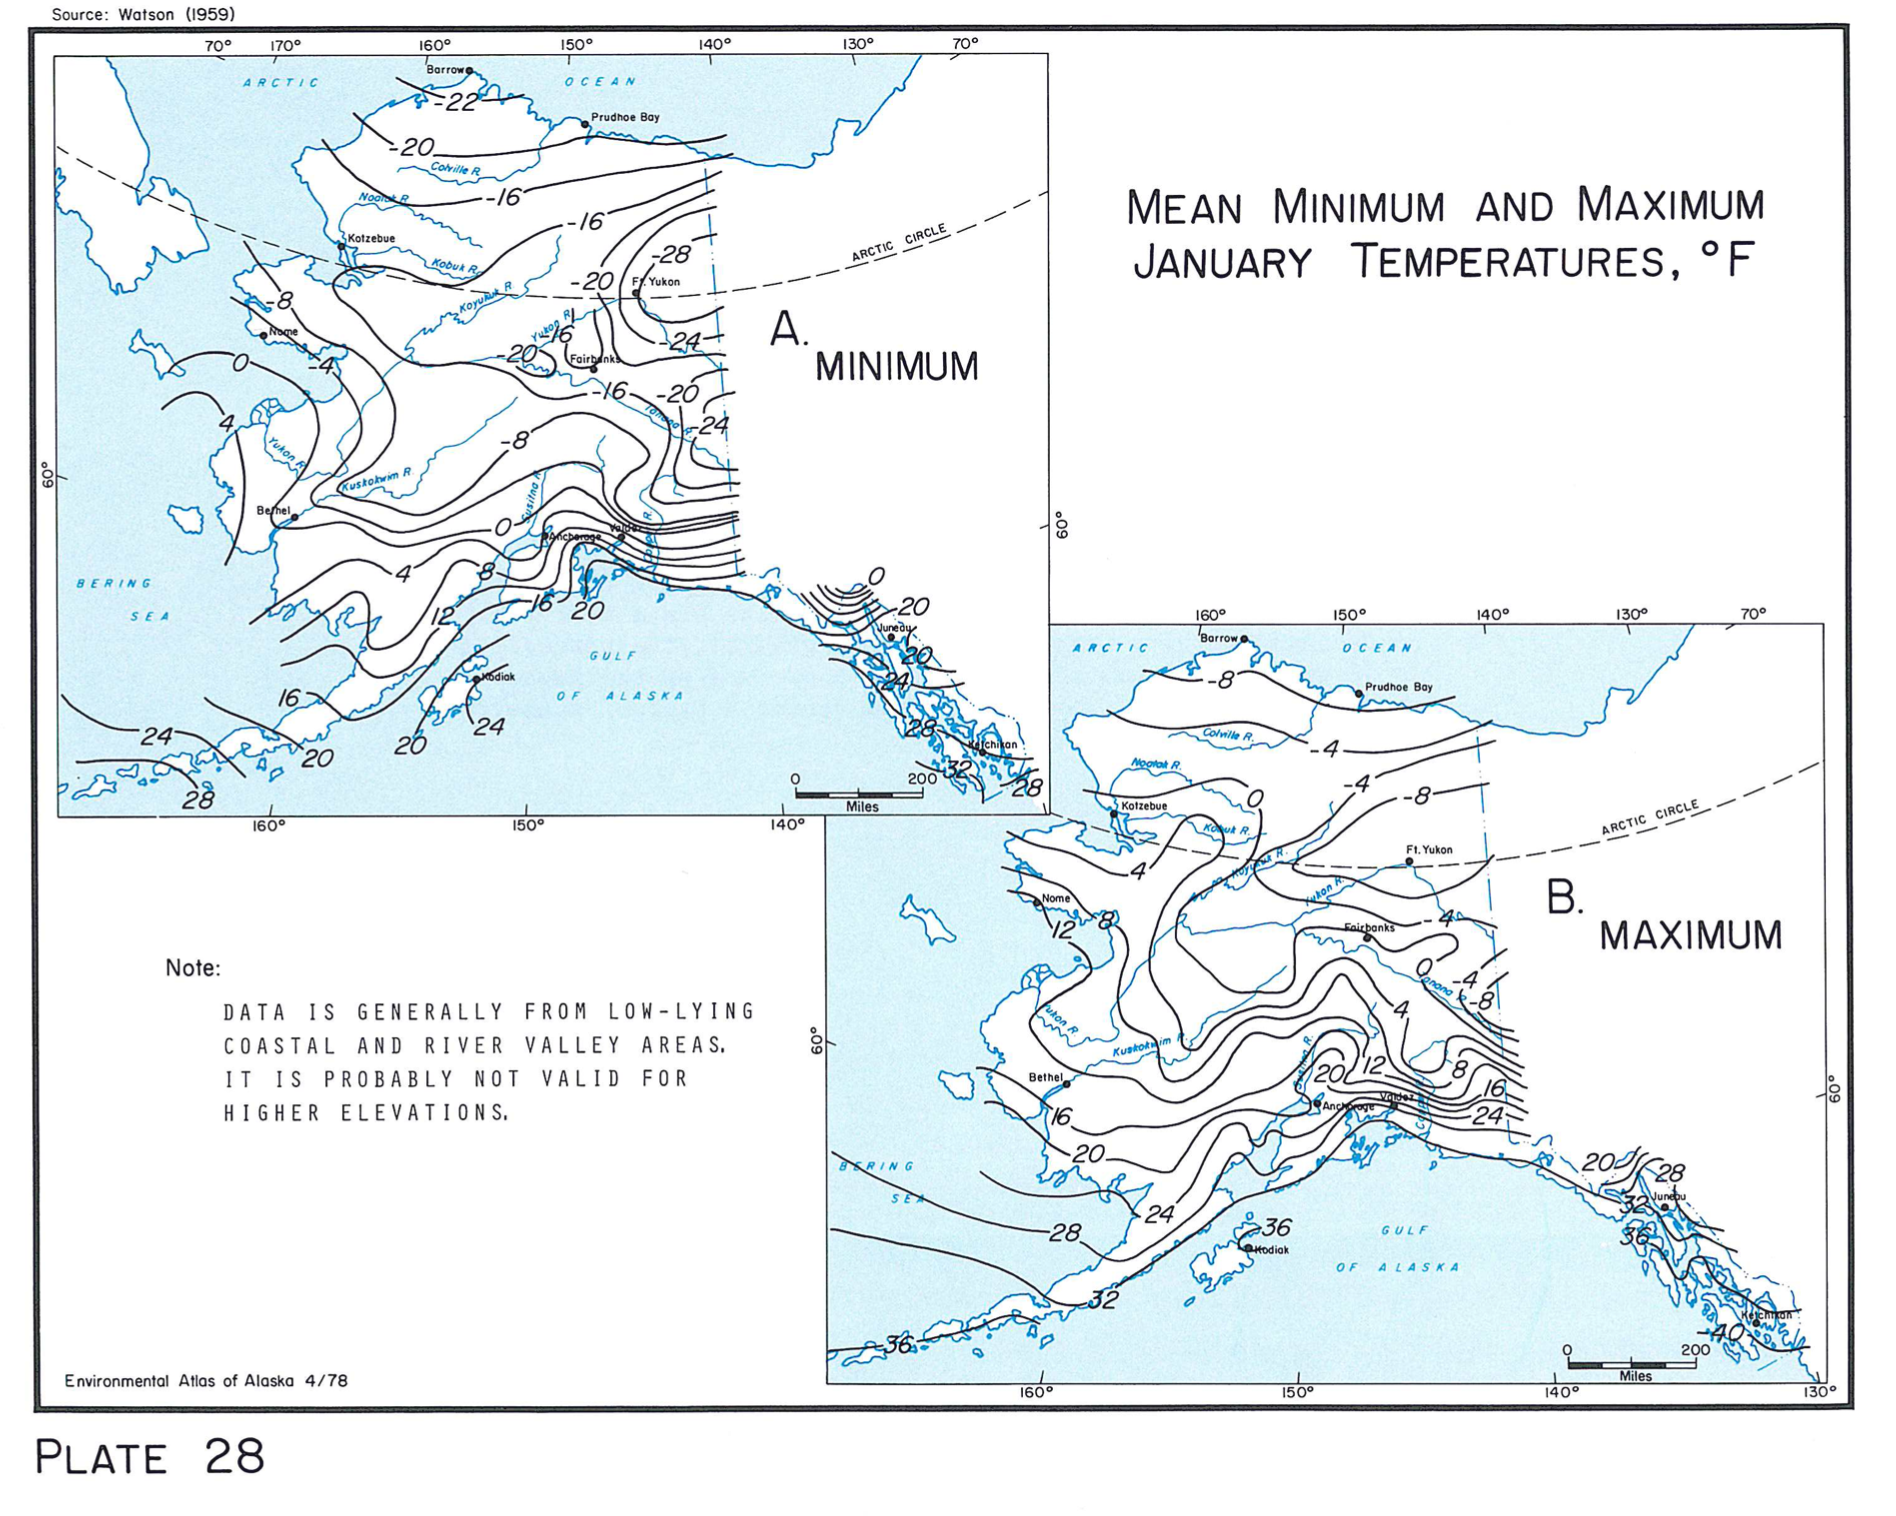

To create modern versions of these plates will want two coverages in Rasdaman, one for each plate (month).

## Replacement Data
There are two datasets that we'll pull from to revamp these plates.

### Historical 
 - CKAN entry: [Historical Monthly and Derived Temperature Products Downscaled from CRU TS data via the delta method - 2 km](http://ckan.snap.uaf.edu/dataset/historical-monthly-and-derived-temperature-products-downscaled-from-cru-ts-data-via-the-delta-m)
 - This dataset has monthly temperature products downscaled from CRU TS data via the delta method.
 - 2 km spatial resolution.
 - CRU TS version 4.0. These are essentially interpolated observations.
 - Range: 1901 - 2015
 
### Projected
 - CKAN entry: [Projected Monthly and Derived Temperature Products - 2km CMIP5/AR5](http://ckan.snap.uaf.edu/dataset/projected-monthly-and-derived-temperature-products-2km-cmip5-ar5)
 - This dataset has projected monthly temperature products from various CMIP5/AR5 situations.
 - 2 km spatial resolution
 - Scenarios: RCP 4.5, RCP 6.0, RCP 8.5
 - Models: GFDL-CM3, NCAR-CCSM4, GISS-E2-R, MRI-CGCM3, IPSL-CM5A-LR, 5-Model Average
 - Range: 2006 - 2100
 - Downscaling: Delta with a PRISM 1961 - 1990 baseline.
 
 ### Structure
 Once unzipped, these data are GeoTIFFs where each file is a single month of a single year for a single model/scenario (or historical) combination.

For the january coverage we'll want a coverage in Rasdaman with the following axes (besides x and y):
 - Year
 - Model
 - Scenario
 - Temperature Statistic (one of mean, minimum, or maximum).

## Processing
We don't actually need to do much because this dataset is already "production-grade" - meaning it used in other apps and is a seminal dataset in our CKAN data portal. However, we will want to clip the rasters to a mask of Alaska, and crop to the extent of that resulting data. I recommend you jump on an *ATLAS* compute node to do the data processing.

```sh
cd $YOUR_SCRATCH_DIRECTORY

cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/projected/AR5_CMIP5_models/Projected_Monthly_and_Derived_Temperature_Products_2km_CMIP5_AR5/monthly/ .

cd monthly
# This will take a while - go get some fresh air.
unzip \*.zip

# Verify the GeoTIFFs extracted consistently
 ls tasmin/tasmin_mean_C_ar5_*_01_* | wc -l
 ls tasmin/tasmin_mean_C_ar5_*_07_* | wc -l
 ls tasmax/tasmax_mean_C_ar5_*_07_* | wc -l
 ls tasmax/tasmax_mean_C_ar5_*_01_* | wc -l
 ls tas/tas_mean_C_AR5_*_01_* | wc -l
 ls tas/tas_mean_C_AR5_*_07_* | wc -l

# Each month and temperature statistic combination should have 1710 GeoTIFFs (6 models X 3 scenarios X 95 years).

# Get these data ready to transfer over to one of the Rasdaman servers (Zeus or Apollo).
mkdir jan
mkdir july
# Steady now...no guardrails on mv
mv tas/tas_mean_C_AR5_*_07_* july/
mv tasmin/tasmin_mean_C_ar5_*_07_* july
mv tasmax/tasmax_mean_C_ar5_*_07_* july
mv tasmin/tasmin_mean_C_ar5_*_01_* jan/
mv tasmax/tasmax_mean_C_ar5_*_01_* jan/
mv tas/tas_mean_C_AR5_*_01_* jan/

# Now do the same with historical data
# cd back to scratch dir
cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS/tasmax_AK_CAN_2km_CRU_TS40_historical.zip .
cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS/tasmin_AK_CAN_2km_CRU_TS40_historical.zip .
cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS/tas_AK_CAN_2km_CRU_TS40_historical.zip .

unzip \*historical.zip

# Verify how many files are here.
ls tas/*historical_01_* | wc -l
116
ls tas/*historical_07_* | wc -l
115
ls tasmin/*historical_07_* | wc -l
115
ls tasmax/*historical_07_* | wc -l
115
ls tasmax/*historical_01_* | wc -l
115
ls tasmin/*historical_01_* | wc -l
115

# OK it is a little odd there are 116 files for the mean historical January temperatures...let's move these files and take a closer look.

mv tasmin/*historical_01_* jan/
mv tasmax/*historical_01_* jan/
mv tas/*historical_01_* jan/
mv tas/*historical_07_* july
mv tasmin/*historical_07_* july
mv tasmax/*historical_07_* july

# An xml file snuck in there (hello GIS!) and should be deleted. 
rm jan/tas_mean_C_CRU_TS40_historical_01_1902.tif.aux.xml

```
Woo! Ok now `jan` and `july` should have the same numer of files (5475) and data volume (14G) within. 

Let's look at the file naming convention because that will dictate the ingest and we should strive for consistency between how the historical and projected data are named.

```
tasmin_mean_C_CRU-TS40_historical_07_2003.tif

tasmin_mean_C_ar5_5ModelAvg_rcp60_07_2039.tif

tas_mean_C_AR5_GFDL-CM3_rcp45_07_2099.tif

tasmax_mean_C_ar5_MRI-CGCM3_rcp60_07_2006.tif

tasmax_mean_C_ar5_5ModelAvg_rcp45_07_2014.tif

tas_mean_C_CRU_TS40_historical_07_1938.tif
```

I don't love these file names. "mean_C" and "AR5" or "ar5" are redundant. I think we can rename these to be more succinct and consistent for a naming convention that reads "tasvariable_model_scenario_year" where "tasvariable" is either tasmin, tasmax, or tasmean. For the historical "model" we can use "CRU-TS" and for the "scenario" we'll retain "historical" - and that syntax is consistent with what we have in other data coverages.

##### Rename the historical files
Do this for both the `jan` and `july` directories and remove "echo" if the command output looks correct (again, mv-ing with no guardrails here so keep your head on a swivel out there). You can also pipe the command as is to bash to actually execute it.


```sh
for f in *historical*; do echo mv "$f" "${f/_mean_C_/_}"; done 
for f in *historical*; do echo mv "$f" "${f/TS40/TS}"; done 
# for jan
for f in *historical*; do echo mv "$f" "${f/historical_01/historical}"; done 
# for july
for f in *historical*; do echo mv "$f" "${f/historical_07/historical}"; done 
for f in *tas_CRU*; do echo mv "$f" "${f/tas_CRU_TS/tasmean_CRU-TS}"; done
```

For the projected file names, we can just remove the redundant pieces and drop the numeric month indicator. The cases of the 5m(M)odel average and missing "NCAR-" in "NCAR-CCSM4" must be made consistent as well (for the july files only?).

```sh
for f in *ar5*; do echo mv "$f" "${f/_mean_C_ar5/}"; done
for f in *AR5*; do echo mv "$f" "${f/_mean_C_AR5/}"; done
# for jan
for f in *rcp*; do echo mv "$f" "${f/_01_/_}"; done
# for july
for f in *rcp*; do echo mv "$f" "${f/_07_/_}"; done
for f in *tas_*; do echo mv "$f" "${f/tas_/tasmean_}"; done
for f in *5Mo*; do echo mv "$f" "${f/5Mo/5mo}"; done
for f in *_CCSM4_*; do echo mv "$f" "${f/_CCSM4_/_NCAR-CCSM4_}"; done
```

For the last step, we want to "clip" the raster data to the footprint of Alaska. It is also good practice to make sure these data have identical metadata and correct and consistent (-9999) no data values. We can force this via gdalwarp. This is also nice because we can be confident that all files were last touched by a common version of GDAL.

For the `-cutline` flag, we will use the ["Alaska Coast Simplified" shapefile from the ua-snap/geospatial-vector-veracity repo](https://github.com/ua-snap/geospatial-vector-veracity/blob/600edb9c24a0000e67ff19b439458f25a2a07863/vector_data/polygon/boundaries/alaska_coast_simplified/Alaska_Coast_Simplified_Polygon.shp), so make sure that repo is cloned somewhere on the system, and save the path to that shapefile in the `AK_COAST_SHP` environment variable, e.g.:

```sh
export AK_COAST_SHP=/workspace/UA/kmredilla/geospatial-vector-veracity/vector_data/polygon/boundaries/alaska_coast_simplified/Alaska_Coast_Simplified_Polygon.shp
```

It might be best to do this via python so we can easily make use of multiple cores. Make sure the `AK_COAST_SHP` and `SCRATCH_DIR` environment variables are set. `SCRATCH_DIR` should be the path to the parent directory of `jan/` and `july/` directories.

First, we actually want to modify the shapefile linked above to have a 20km buffer, to retain as much of the valid data values around the coasts as possible during the masking. Make sure the path to the Alaska coast shapefile is saved in the `AK_COAST_SHP` environment variable, and create a new shapefile and save it in the `scratch_dir` (note, skips this if it's already present at expected path):

In [1]:
import os
from pathlib import Path

scratch_dir = Path(os.getenv("SCRATCH_DIR"))

# This is set up to be created from multiple preprocessing notebooks,
# so this cell can be ignored if it already exists
ak_buffered_coast_shp = scratch_dir.parent.joinpath("shapefiles/alaska_coast_simplfied.shp")
if ak_buffered_coast_shp.exists():
    print("Buffered AK coast shapefile already exists")
    pass
else:

    import os
    import geopandas as gpd


    ak_coast_shp = os.getenv("AK_COAST_SHP")
    ak_coast_gdf = gpd.read_file(ak_coast_shp)
    ak_coast_buffered_gdf = ak_coast_gdf.copy()
    ak_coast_buffered_gdf["geometry"] = ak_coast_gdf.buffer(20000)
    ak_buffered_coast_shp = scratch_dir.joinpath("shapefiles/alaska_coast_simplfied.shp")
    ak_buffered_coast_shp.parent.mkdir(exist_ok=True)
    ak_coast_buffered_gdf.to_file(ak_buffered_coast_shp)

Buffered AK coast shapefile already exists


Rename the `jan/` and `july/` directories, as we will want to save the newly cropped data to directories with these names:

```sh
mv jan jan_original
mv july july_original
mkdir jan
mkdir july
```

Then, execute the code cell below to run the `gdalwarp` command in parallel for July:

In [2]:
ncores = 64


from subprocess import call
from multiprocessing import Pool
from tqdm import tqdm


ak_coast_shp = os.getenv("AK_COAST_SHP")

args = []
for fp in scratch_dir.glob("july_original/*.tif"):
    out_fp = scratch_dir.joinpath(f"july/{fp.name}")
    command = [
        "gdalwarp",
        "-t_srs",
        "EPSG:3338",
        "-dstnodata",
        "-9999",
        "-co",
        "COMPRESS=LZW",
        str(fp),
        str(out_fp),
        "-cutline",
        ak_buffered_coast_shp,
        "-crop_to_cutline",
        "-q",
    ]
    args.append(command)


with Pool(ncores) as pool:
    _ = [
        result for result in tqdm(
            pool.imap_unordered(call, args), 
            total=len(args),
            desc=f"Clipping July data",
        )
    ]

Clipping July data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5475/5475 [01:36<00:00, 57.02it/s]


In [3]:
args = []
for fp in scratch_dir.glob("jan_original/*.tif"):
    out_fp = scratch_dir.joinpath(f"jan/{fp.name}")
    command = [
        "gdalwarp",
        "-t_srs",
        "EPSG:3338",
        "-dstnodata",
        "-9999",
        "-co",
        "COMPRESS=LZW",
        str(fp),
        str(out_fp),
        "-cutline",
        ak_buffered_coast_shp,
        "-crop_to_cutline",
        "-q",
    ]
    args.append(command)


with Pool(ncores) as pool:
    _ = [
        result for result in tqdm(
            pool.imap_unordered(call, args), 
            total=len(args),
            desc=f"Clipping January data",
        )
    ]

Clipping January data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5475/5475 [01:36<00:00, 56.80it/s]


## Quality 

Check out the resulting files as a sanity check:

### January

In [5]:
import numpy as np


out_fps = sorted(list(scratch_dir.glob("jan/*.tif")))
print(f"Number of files: {len(out_fps)}")

sizes = [round(fp.stat().st_size / 1e6, 1) for fp in out_fps]
print(f"Unique file sizes (MB): {np.unique(sizes, return_counts=True)}")

Number of files: 5475
Unique file sizes (MB): (array([1. , 1.1]), array([5188,  287]))


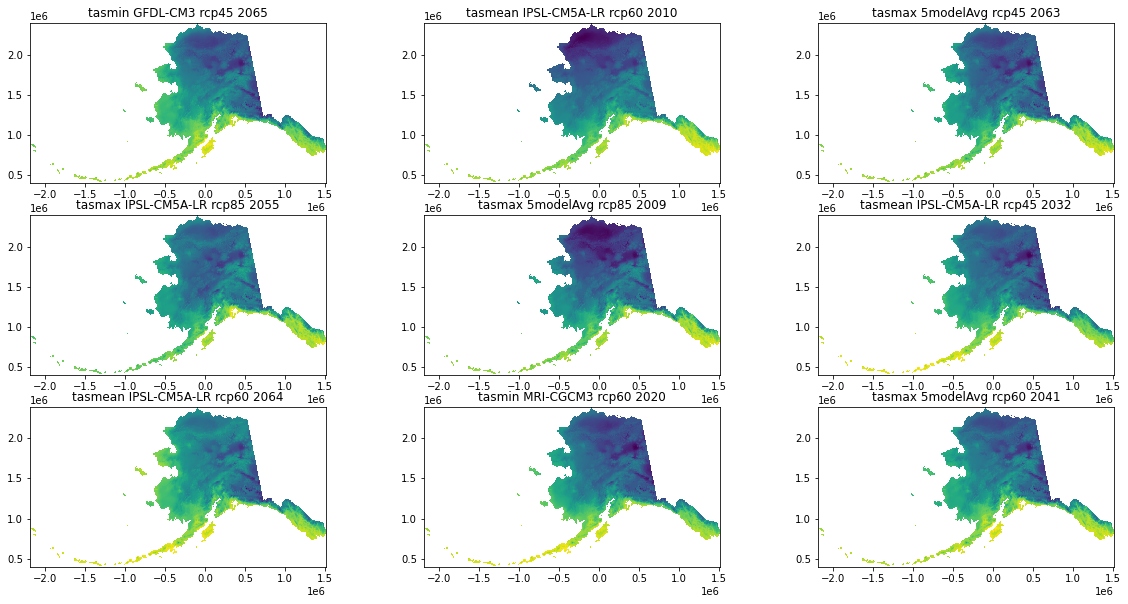

In [6]:
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show


fig, axs = plt.subplots(3, 3, figsize=(20, 10))

arrs = []
titles = []
for ax in axs.flatten():
    i = np.random.randint(len(out_fps))
    fp = out_fps[i]
    with rio.open(fp) as src:
        show(src, ax=ax, interpolation="none")
        arrs.append(src.read(1))
    title = " ".join(fp.name.split(".")[0].split("_"))
    ax.set_title(title)
    titles.append(title)

plt.show()

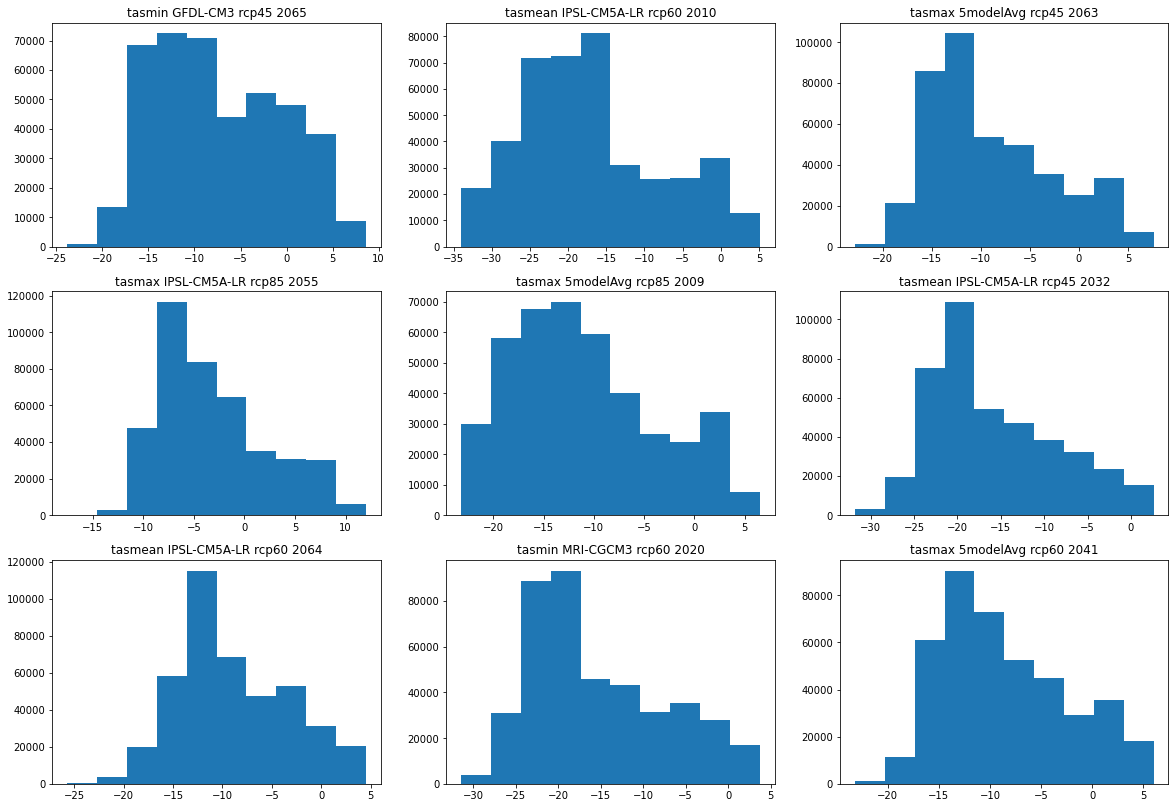

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(20, 14))
for ax, arr, title in zip(axs.flatten(), arrs, titles):
    arr = arr.flatten()
    arr = arr[arr != -9999]
    ax.hist(arr)
    ax.set_title(title)

plt.show()

### July

In [8]:
out_fps = sorted(list(scratch_dir.glob("july/*.tif")))
print(f"Number of files: {len(out_fps)}")

sizes = [round(fp.stat().st_size / 1e6, 1) for fp in out_fps]
print(f"Unique file sizes (MB): {np.unique(sizes, return_counts=True)}")

Number of files: 5475
Unique file sizes (MB): (array([0.9, 1. ]), array([ 220, 5255]))


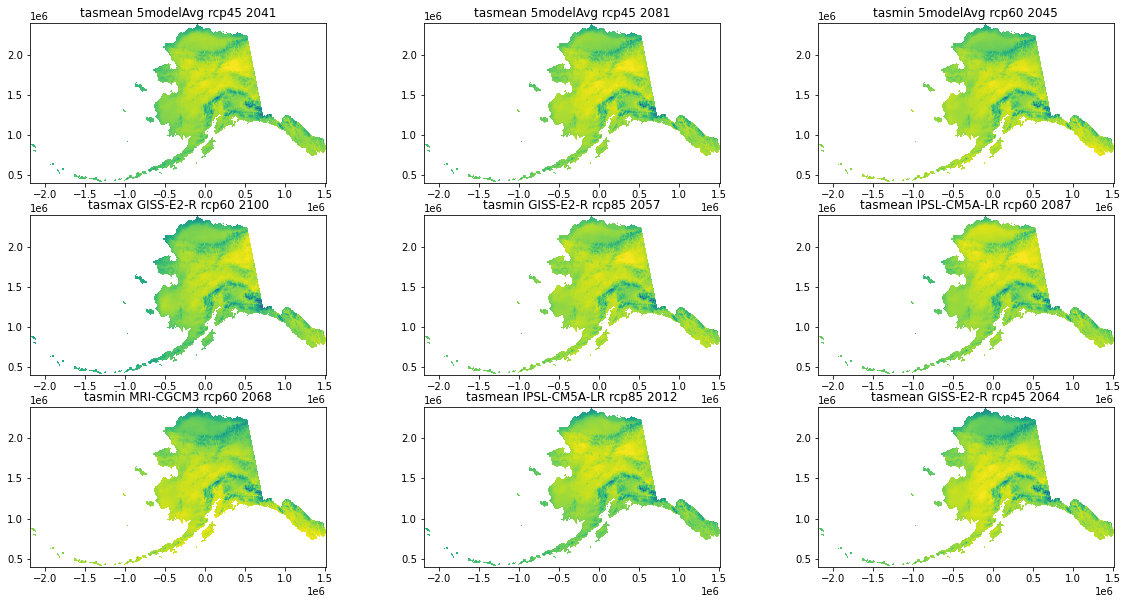

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))

arrs = []
titles = []
for ax in axs.flatten():
    i = np.random.randint(len(out_fps))
    fp = out_fps[i]
    with rio.open(fp) as src:
        show(src, ax=ax, interpolation="none")
        arrs.append(src.read(1))
    title = " ".join(fp.name.split(".")[0].split("_"))
    ax.set_title(title)
    titles.append(title)

plt.show()

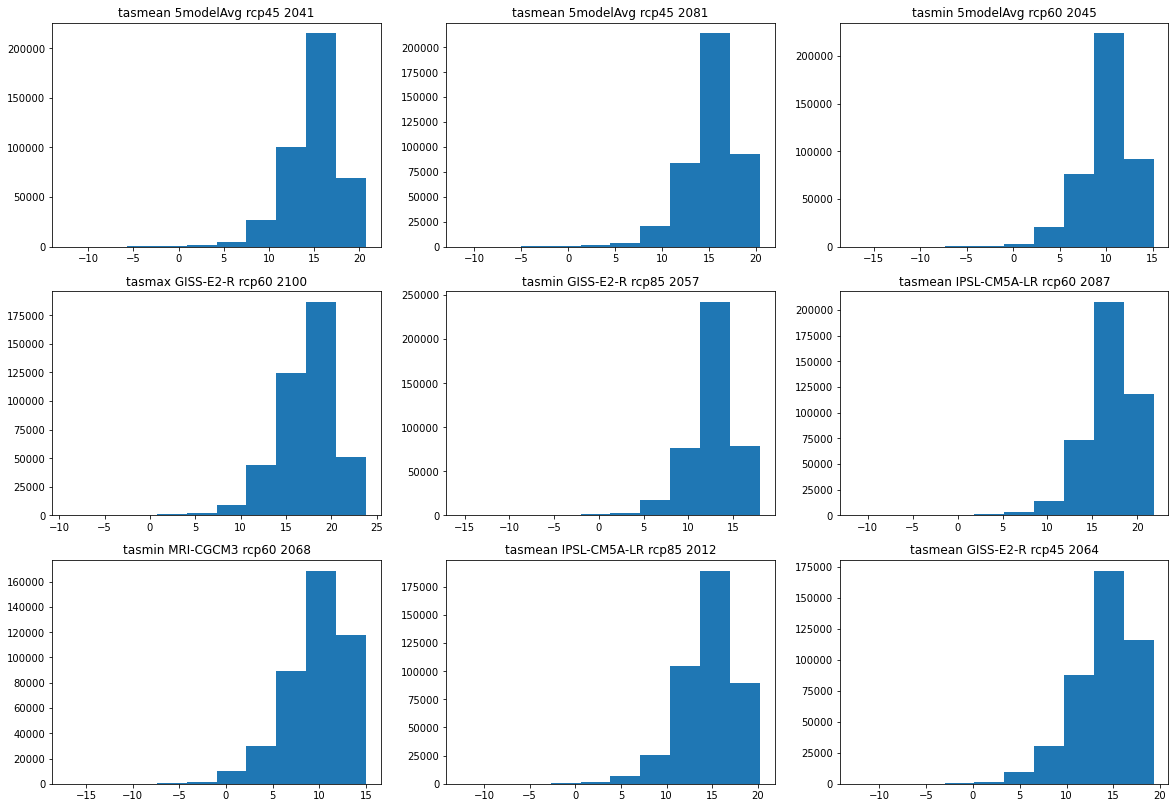

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(20, 14))
for ax, arr, title in zip(axs.flatten(), arrs, titles):
    arr = arr.flatten()
    arr = arr[arr != -9999]
    ax.hist(arr)
    ax.set_title(title)

plt.show()

OK at this point these data are basically ready for ingest!
The data now need to be moved to a Rasdaman server (Apollo, Zeus).


```sh
scp -r jan/ cparr4@apollo.snap.uaf.edu:
scp -r july/ cparr4@apollo.snap.uaf.edu:
```
These directories are now in your home directory on Apollo.